In [1]:
import torch
from transformers import Trainer, TrainingArguments
from transformers import BartForConditionalGeneration, BartTokenizer
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import os
from datasets import load_dataset,load_metric
# from evaluate import load_metric
from sklearn.model_selection import train_test_split

device = 'cuda:0'
import emoji
emoji_list = emoji.EMOJI_DATA.keys()
emoji_descriptions = [emoji.demojize(e, delimiters=("<", ">")) for e in emoji_list]

### Loading the base models from Huggingface


In [2]:
model_name = "facebook/bart-base"
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)


In [3]:
model

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50265, 768, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): Embedding(50265, 768, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 768)
      (layers): ModuleList(
        (0-5): 6 x BartEncoderLayer(
          (self_attn): BartAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), eps=

In [4]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
# tokenizer2 = AutoTokenizer.from_pretrained(model_name)

new_tokens = ['<file_photo>','<file_picture>','<file_other>','<file_video>','<file_image>','<file_gif>']
new_tokens = new_tokens+emoji_descriptions
tokenizer.add_special_tokens({'additional_special_tokens': new_tokens})
model.resize_token_embeddings(len(tokenizer))

Embedding(54053, 768)

### Loading the SAMSum dataset

In [5]:
# Load the Samsum dataset
dataset = load_dataset("samsum")

train_data = dataset["train"]
validation_data = dataset["validation"] 
test_data = dataset["test"]

### Tokenizing Function

In [6]:
# Tokenzing
def tokenize_function(tokenizer,examples):
    input_dialogues = ["Summarize dialogue >>\n " + emoji.demojize(dialogue, delimiters=("<", ">")) for dialogue in examples["dialogue"]]
    inputs = tokenizer(input_dialogues, padding="max_length", truncation=True, max_length=1000)
    targets = tokenizer(examples["summary"], padding="max_length", truncation=True, max_length=100)
    return {"input_ids": inputs["input_ids"], "attention_mask": inputs["attention_mask"], "labels": targets["input_ids"]}


In [7]:
train_data_tokenized = train_data.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)
validation_data_tokenized = validation_data.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)
test_data_tokenized = test_data.map(lambda examples: tokenize_function(tokenizer, examples), batched=True)


Token indices sequence length is longer than the specified maximum sequence length for this model (1078 > 1024). Running this sequence through the model will result in indexing errors


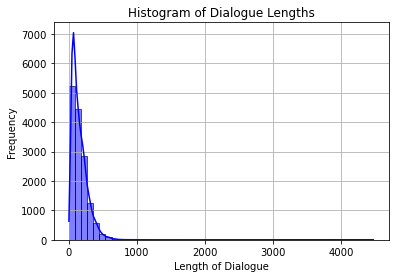

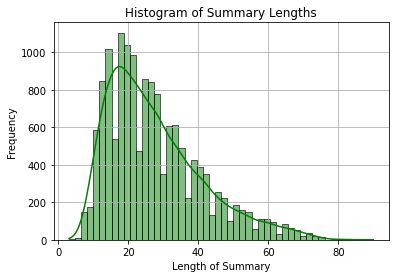

In [8]:
d_len = [len(tokenizer.encode(s)) for s in train_data["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in train_data["summary"]]

import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(d_len, bins=50, color='blue', kde=True)
plt.xlabel('Length of Dialogue')
plt.ylabel('Frequency')
plt.title('Histogram of Dialogue Lengths')
plt.grid(True)
plt.show()
# plt.save("input_length.png")
sns.histplot(s_len, bins=50, color='green', kde=True)
plt.xlabel('Length of Summary')
plt.ylabel('Frequency')
plt.title('Histogram of Summary Lengths')
plt.grid(True)
plt.show()
# plt.save("summary_length.png")

### Sample summarization code

In [8]:
def summarize(tokenizer,model,text):
#     print(f"Summarize dialogue >>\n {emoji.demojize(text, delimiters=('<', '>'))}")
    inputs = tokenizer(f"Summarize dialogue >>\n {emoji.demojize(text, delimiters=('<', '>'))}", return_tensors="pt", max_length=1000, truncation=True, padding="max_length").to(device)
    
    # Generate summary
    summary_ids = model.generate(inputs.input_ids, num_beams=4, max_length=100, early_stopping=True)
    # Decode the summary
    summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    return summary[0]


### Model - BART

In [9]:
# for name, param in bart_base_model.named_parameters():
#     if param.requires_grad:
#         print(name)
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Trainable parameters:", trainable_params)        
#247577856/142329600

Trainable parameters: 142329600


### Training

In [10]:
output_dir = "./bart_base_full_finetune_emoji"
# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)

In [11]:
training_args = TrainingArguments(
#     eval_device='cpu',
    overwrite_output_dir = False,
    output_dir=output_dir,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
#     evaluation_strategy="steps",
    logging_dir=f"{output_dir}/logs",
    logging_steps=500,
    save_strategy="epoch",
    save_total_limit=3,
    num_train_epochs=20,
    learning_rate=1e-4,
)

rouge_metric = load_metric("rouge")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_data_tokenized,
    eval_dataset=validation_data_tokenized,
#     compute_metrics=lambda pred: rouge_metric.compute(predictions=pred.predictions, references=pred.label_ids)
)

# trainer = Trainer( 
#     model=bart_base_model,
#     args=training_args,
#     train_dataset=train_data_tokenized
# )

<ipython-input-11-6f3242da5164>:16: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")
/home/sampgaon.h/.local/lib/python3.8/site-packages/datasets/load.py:756: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [12]:
trainer.train(resume_from_checkpoint = True)

/home/sampgaon.h/.local/lib/python3.8/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
52000,0.042000
52500,0.045400
53000,0.046000
53500,0.046800
54000,0.047300
54500,0.047300
55000,0.048400
55500,0.040100
56000,0.034700
56500,0.036400


TrainOutput(global_step=73660, training_loss=0.008332738735868074, metrics={'train_runtime': 8925.9558, 'train_samples_per_second': 33.009, 'train_steps_per_second': 8.252, 'total_flos': 1.754421387264e+17, 'train_loss': 0.008332738735868074, 'epoch': 20.0})

In [13]:
trainer.save_model('./bart_base_full_finetune_emoji_save-20')


eval_trainer = Trainer(
    model=model,
    eval_dataset=validation_data_tokenized,
    compute_metrics=lambda pred: rouge_metric.compute(predictions=pred.predictions, references=pred.label_ids)
)

# Evaluate the model on the test set
results = eval_trainer.evaluate(test_data)
# results = trainer.evaluate(test_data)
print("ROUGE scores:", results)

ROUGE scores: {'eval_runtime': 0.0018, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0}


In [14]:
# output_dir = './tokenizer'
tokenizer.save_pretrained('./tokenizer-emoji-20')


('./tokenizer-emoji-20/tokenizer_config.json',
 './tokenizer-emoji-20/special_tokens_map.json',
 './tokenizer-emoji-20/vocab.json',
 './tokenizer-emoji-20/merges.txt',
 './tokenizer-emoji-20/added_tokens.json',
 './tokenizer-emoji-20/tokenizer.json')

In [12]:
results = eval_trainer.evaluate(test_data)
# results = trainer.evaluate(test_data)
print("ROUGE scores:", results)

ROUGE scores: {'eval_runtime': 0.0025, 'eval_samples_per_second': 0.0, 'eval_steps_per_second': 0.0}


In [15]:
# orignal_model = 

model_name = "facebook/bart-base"
orignal_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
orignal_model_tok = AutoTokenizer.from_pretrained(model_name)


### ROUGE SCORE -- inference


In [15]:
def summarize(tokenizer,model,text):
    """
    Summarizes the given text using the provided tokenizer and model.

    Args:
        tokenizer (Tokenizer): The tokenizer used to tokenize the input text.
        model (Model): The model used for summarization.
        text (str): The text to be summarized.

    Returns:
        list: A list containing the summarized text.    
    """    
    
    inputs = tokenizer(f"Summarize dialogue >>\n {emoji.demojize(text, delimiters=('<', '>'))}", return_tensors="pt", max_length=1000, truncation=True, padding="max_length").to(device)
    
    # Generate summary
    summary_ids = model.generate(inputs.input_ids, num_beams=4, max_length=100, early_stopping=True)
    # Decode the summary
    summary = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]
    
    return summary


generated_summaries = []
actual_summaries = []
generated_summary_orignal = []
dialogue_list = []
SAVED_MODEL_PATH = './bart_base_full_finetune_emoji_save-20'
SAVED_TOK_PATH = 'tokenizer-emoji'
SAVED_MODEL_TOK = BartTokenizer.from_pretrained(SAVED_TOK_PATH)#.to(device)
SAVED_MODEL = BartForConditionalGeneration.from_pretrained(SAVED_MODEL_PATH).to(device)


model_name = "facebook/bart-base"
orignal_model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)
orignal_model_tok = AutoTokenizer.from_pretrained(model_name)


### Inference loop to generate summaries on test dataset for ROUGE metrics

In [16]:
import time
start_time = time.time()
i=1
j=0
for example in test_data:
    if i%10==0:
#         print()
        j+=10
        print(f"samples summarized:{j}\ttime:{time.time()-start_time}")
#         print(f"",)
#     print(example['dialogue'])
    generated_summary = summarize(SAVED_MODEL_TOK,SAVED_MODEL,example['dialogue'])
    generated_summaries.append(generated_summary[0])
    generated_summary_o = summarize(orignal_model_tok,orignal_model,example['dialogue'])
    generated_summary_orignal.append(generated_summary_o[0])
    actual_summaries.append(example["summary"])
    dialogue_list.append(example['dialogue'])
    
    i+=1
    
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

samples summarized:10	time:13.612424612045288
samples summarized:20	time:28.75102138519287
samples summarized:30	time:43.87571144104004
samples summarized:40	time:56.96833825111389
samples summarized:50	time:70.36589527130127
samples summarized:60	time:83.7672266960144
samples summarized:70	time:96.55684280395508
samples summarized:80	time:110.15830326080322
samples summarized:90	time:124.33040595054626
samples summarized:100	time:137.63712406158447
samples summarized:110	time:148.71072840690613
samples summarized:120	time:162.8433039188385
samples summarized:130	time:175.4967179298401
samples summarized:140	time:189.71921372413635
samples summarized:150	time:202.7748260498047
samples summarized:160	time:216.24117279052734
samples summarized:170	time:229.35436511039734
samples summarized:180	time:242.84064030647278
samples summarized:190	time:256.6531422138214
samples summarized:200	time:270.6927156448364
samples summarized:210	time:284.8746464252472
samples summarized:220	time:298.653

In [18]:
sum(p.numel() for p in bart_base_model.parameters() if p.requires_grad),sum(p.numel() for p in SAVED_MODEL.parameters() if p.requires_grad)

(139420416, 139420416)

## ROUGE for orignal base model

In [20]:
from rouge_score import rouge_scorer

start_time = time.time()

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = [scorer.score(actual_summary, gen_summary) for actual_summary, gen_summary in zip(actual_summaries, generated_summary_orignal)]
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

start_time = time.time()

# To calculate average scores
average_scores = {}
for key in scores[0].keys():
    average_scores[key] = sum(score[key].fmeasure for score in scores) / len(scores)

    
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")    
print("Average ROUGE scores:")
for key, value in average_scores.items():
    print(f"{key}: {value}")


Total time taken: 1.2444276809692383 seconds
Total time taken: 0.0004544258117675781 seconds
Average ROUGE scores:
rouge1: 0.26169222463055913
rouge2: 0.08215245169992622
rougeL: 0.1960244210163297


In [22]:
import pandas as pd


temp_df = pd.DataFrame({'finetune_summary':generated_summaries,'original_summary':generated_summary_orignal,'human_summary':actual_summaries,'dialog':dialogue_list})

In [23]:
temp_df.to_csv('bart_base_full_results_20_epoch.csv')#.loc[3][0]

### ROUGE for fine-tuned model

In [21]:
from rouge_score import rouge_scorer

start_time = time.time()

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
scores = [scorer.score(actual_summary, gen_summary) for actual_summary, gen_summary in zip(actual_summaries, generated_summaries)]
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")

start_time = time.time()

# To calculate average scores
average_scores = {}
for key in scores[0].keys():
    average_scores[key] = sum(score[key].fmeasure for score in scores) / len(scores)

    
end_time = time.time()
total_time = end_time - start_time
print(f"Total time taken: {total_time} seconds")    

print("Average ROUGE scores:")
for key, value in average_scores.items():
    print(f"{key}: {value}")


Total time taken: 0.68064284324646 seconds
Total time taken: 0.00043010711669921875 seconds
Average ROUGE scores:
rouge1: 0.49138317625335387
rouge2: 0.23691595277228433
rougeL: 0.39797541931784813


In [38]:
import huggingface_hub

In [40]:
model_tok_save_directory = "./bart_base_full_finetune_model_tokenizer"
SAVED_MODEL.save_pretrained(model_tok_save_directory)
SAVED_MODEL_TOK.save_pretrained(model_tok_save_directory)


('./bart_base_full_finetune_model_tokenizer/tokenizer_config.json',
 './bart_base_full_finetune_model_tokenizer/special_tokens_map.json',
 './bart_base_full_finetune_model_tokenizer/vocab.json',
 './bart_base_full_finetune_model_tokenizer/merges.txt',
 './bart_base_full_finetune_model_tokenizer/added_tokens.json')

In [ ]:
from huggingface_hub import Repository

repo = Repository(local_dir=model_tok_save_directory, clone_from=f"hrs19/bart_base_SAMsum_full_finetune")
repo.git_add()
repo.git_commit("First commit with custom model and tokenizer with additional tokens for emojis and <file_share>")
repo.git_push()
